In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader 
from dataset import DuplicateDataset
from nltk.tokenize import word_tokenize

from utils import get_test_questions, get_vocab_train_questions, get_tensors
from train_evaluate import TrianEvaluate
from model import DuplicatesNetwork
from utils import predict 

import matplotlib.pyplot as plt 
from tqdm import tqdm 


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 64 
num_workers = 12
max_length = 55
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Analysis

In [3]:
data = pd.read_csv('questions.csv')
data = data.drop(['id', 'qid2', 'qid1'], axis = 1)
duplicaate_data = data[data['is_duplicate'] == 1]
duplicaate_data.head()

,question1,question2,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,How can I be a good geologist?,What should I do to be a great geologist?,1
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,What was your first sexual experience like?,What was your first sexual experience?,1


In [4]:
train_data, test_data = train_test_split(duplicaate_data, test_size = 0.1, random_state = 42)
train_data.head()

,question1,question2,is_duplicate
275470,How can I stop temptation to watch porn?,How can I stop watching porn?,1
317036,Why is Hillary Clinton considered corrupt?,Are the Clintons corrupt?,1
48584,What recommendations would you like to give to...,Recommendations to Walt Disney?,1
214600,How do I hack into someone WiFi network?,How to hack Wifi?,1
68229,What are some best ways to earn money in a par...,What are the good ways to earn money from part...,1


In [5]:
question1_train = train_data.question1.values
question1_test = test_data.question1.values

question2_train = train_data.question2.values
question2_test = test_data.question2.values

print(f'Total Number of Training Samples for Q1 (non-duplicates) = {len(question1_train)}')
print(f'Total Number of Testing Samples for Q1 (non-duplicates) = {len(question1_test)}')

print(f'Total Number of Training Samples for Q2 (non-duplicates) = {len(question2_train)}')
print(f'Total Number of Testing Samples for Q2 (non-duplicates) = {len(question2_test)}')

print('==================================================================')

print(f'Training Questions: \n Q1: {question1_train[0]} \n Q2: {question2_train[0]}')
print(f'Testing Questions: \n Q1: {question1_test[0]} \n Q2: {question2_test[0]}')

Total Number of Training Samples for Q1 (non-duplicates) = 134375
Total Number of Testing Samples for Q1 (non-duplicates) = 14931
Total Number of Training Samples for Q2 (non-duplicates) = 134375
Total Number of Testing Samples for Q2 (non-duplicates) = 14931
Training Questions: 
 Q1: How can I stop temptation to watch porn? 
 Q2: How can I stop watching porn?
Testing Questions: 
 Q1: What is it like to be undergraduate students? 
 Q2: What is it like to be an undergraduate student?


# Tokenize Data and Get Vocab

In [6]:
vocab, q1_train_tokenized , q2_train_tokenized = get_vocab_train_questions(question1_train, question2_train) 
idx_to_word = {i:d for d,i in vocab.items()}

In [7]:
q1_test_tokenized, q2_test_tokenized = get_test_questions(question1_test, question2_test)

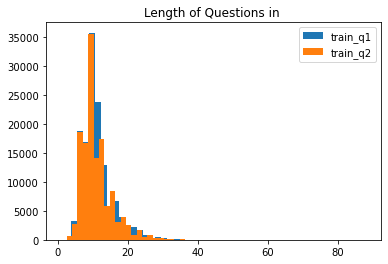

Max len Q1 = 88
Max len Q2 = 78


In [8]:
lens_q1 = [len(i) for i in q1_train_tokenized]
lens_q2 = [len(i) for i in q2_train_tokenized]

max_len_q1 = 0 
max_len_q2 = 0 

for q1, q2 in zip(q1_train_tokenized, q2_train_tokenized): 
    if len(q1) > max_len_q1:
        max_len_q1 = len(q1)
    if len(q2) > max_len_q2:
        max_len_q2 = len(q2) 
plt.hist(lens_q1, label = 'train_q1', bins = 50)
plt.hist(lens_q2, label = 'train_q2', bins = 50)
plt.legend()
plt.title('Length of Questions in ')
plt.show()

print(f'Max len Q1 = {max_len_q1}')
print(f'Max len Q2 = {max_len_q2}')

In [9]:
q1_train_tensor, q2_train_tensor = get_tensors(q1_train_tokenized, q2_train_tokenized, vocab)
q1_test_tensor, q2_test_tensor = get_tensors(q1_test_tokenized, q2_test_tokenized, vocab)

# Get the Dataset and DataLoader 

In [10]:
train_dataset = DuplicateDataset(question1= q1_train_tensor, question2= q2_train_tensor, max_len= max_length)
test_dataset = DuplicateDataset(question1= q1_test_tensor, question2= q2_test_tensor, max_len= max_length)

train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)

# Network 


In [11]:
model = DuplicatesNetwork(vocab_size = len(vocab), d_model = 512, n_LSTM = 3, padd = 1, batch_first = True).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
epochs = 15
margin = 0.8
threshold = 0.80
trainer = TrianEvaluate(model= model, train_loader= train_dataloader, test_loader= test_dataloader, optimizer= optimizer, epochs = epochs, margin = margin, device= device)


In [12]:
train_acc, train_loss = trainer.fit(threshold= threshold)

Epoch 1/15


100%|██████████| 2100/2100 [01:10<00:00, 29.91it/s]


 Loss = 0.908
Accuracy = 0.731 

Epoch 2/15


100%|██████████| 2100/2100 [01:09<00:00, 30.29it/s]


 Loss = 0.511
Accuracy = 0.668 

Epoch 3/15


100%|██████████| 2100/2100 [01:08<00:00, 30.57it/s]


 Loss = 0.295
Accuracy = 0.778 

=== Evaluation Phase ===


100%|██████████| 234/234 [00:04<00:00, 47.79it/s]


Eval Accuracy = 0.785
Epoch 4/15


100%|██████████| 2100/2100 [01:09<00:00, 30.43it/s]


 Loss = 0.212
Accuracy = 0.844 

Epoch 5/15


100%|██████████| 2100/2100 [01:10<00:00, 29.70it/s]


 Loss = 0.170
Accuracy = 0.882 

Epoch 6/15


100%|██████████| 2100/2100 [01:09<00:00, 30.10it/s]


 Loss = 0.143
Accuracy = 0.907 

=== Evaluation Phase ===


100%|██████████| 234/234 [00:05<00:00, 45.70it/s]


Eval Accuracy = 0.838
Epoch 7/15


100%|██████████| 2100/2100 [01:08<00:00, 30.58it/s]


 Loss = 0.127
Accuracy = 0.923 

Epoch 8/15


100%|██████████| 2100/2100 [01:07<00:00, 31.01it/s]


 Loss = 0.113
Accuracy = 0.935 

Epoch 9/15


100%|██████████| 2100/2100 [01:07<00:00, 30.96it/s]


 Loss = 0.105
Accuracy = 0.944 

=== Evaluation Phase ===


100%|██████████| 234/234 [00:04<00:00, 47.13it/s]


Eval Accuracy = 0.849
Epoch 10/15


100%|██████████| 2100/2100 [01:09<00:00, 30.03it/s]


 Loss = 0.099
Accuracy = 0.950 

Epoch 11/15


100%|██████████| 2100/2100 [01:12<00:00, 29.15it/s]


 Loss = 0.093
Accuracy = 0.955 

Epoch 12/15


100%|██████████| 2100/2100 [01:08<00:00, 30.74it/s]


 Loss = 0.088
Accuracy = 0.960 

=== Evaluation Phase ===


100%|██████████| 234/234 [00:04<00:00, 48.66it/s]


Eval Accuracy = 0.855
Epoch 13/15


100%|██████████| 2100/2100 [01:09<00:00, 30.30it/s]


 Loss = 0.085
Accuracy = 0.962 

Epoch 14/15


100%|██████████| 2100/2100 [01:08<00:00, 30.73it/s]


 Loss = 0.081
Accuracy = 0.965 

Epoch 15/15


100%|██████████| 2100/2100 [01:08<00:00, 30.67it/s]


 Loss = 0.080
Accuracy = 0.968 

=== Evaluation Phase ===


100%|██████████| 234/234 [00:04<00:00, 47.93it/s]


Eval Accuracy = 0.855
==================== Final Evaluation ====================
=== Evaluation Phase ===


100%|██████████| 234/234 [00:06<00:00, 37.87it/s]

Eval Accuracy = 0.855


In [14]:
predict(vocab= vocab, model= model, threshold= threshold, device=device)

First Questions is: What is your name? 
Second Questions is: what is your age?
Not Duplicate


In [16]:
predict(vocab= vocab, model= model, threshold= threshold, device=device)

First Questions is: What is your name? 
Second Questions is: What is your given name? 
Duplicate


In [18]:
predict(vocab= vocab, model= model, threshold= threshold, device=device)

First Questions is: How long does it take to reach Dubai from California?
Second Questions is: How far is Dubai from California? 
Duplicate
